In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil, PRMSGroundwater, PRMSStreamflow
from pathlib import Path
import geopandas as gpd
import pandas as pd
import helper

models: Avulsion, Plume, Sedflux3D, Subside, PRMSSurface, PRMSStreamflow, PRMSSoil, PRMSGroundwater, FrostNumber, Ku, Hydrotrend, Cem, Waves


In [2]:
run_dir = '../sagehen_prms6/prms6'
config_surf= 'prms6_surf.control'
config_soil = 'prms6_soil.control'
config_gw = 'prms6_gw.control'
config_sf = 'prms6_strm.control'
print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
print((Path(run_dir) / config_gw).exists())
print((Path(run_dir) / config_sf).exists())
msurf = PRMSSurface()
msoil = PRMSSoil()
mgw = PRMSGroundwater()
msf = PRMSStreamflow()

print(msurf.name)


True
True
True
True
True
prms6-surface-BMI


In [3]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)
mgw.initialize(config_gw, run_dir)
msf.initialize(config_sf, run_dir)

In [4]:
# surf2soil_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru',
#                   'dprst_seep_hru', 'infil', 'sroff', 'potet', 'hru_intcpevap',
#                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max',
#                   'soil_moist', 'soil_moist_max', 'hru_impervevap',
#                   'srunoff_updated_soil', 'transp_on']

surf2soil_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv',
                  'infil', 'sroff', 'potet', 'hru_intcpevap',
                  'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max',
                  'soil_moist', 'soil_moist_max', 'hru_impervevap',
                  'srunoff_updated_soil', 'transp_on']

surf2soil_cond_vars = ['dprst_evap_hru', 'dprst_seep_hru']

soil_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

# surf2gw_vars = ['pkwater_equiv', 'dprst_seep_hru', 'dprst_stor_hru', 'hru_intcpstor',
#                 'hru_impervstor', 'sroff']

surf2gw_vars = ['pkwater_equiv', 'hru_intcpstor', 'hru_impervstor', 'sroff']

surf2gw_cond_vars = ['dprst_seep_hru', 'dprst_stor_hru']

soil2gw_vars = ['soil_moist_tot', 'soil_to_gw', 'ssr_to_gw', 'ssres_flow']

surf2sf_vars = ['potet', 'swrad', 'sroff']

soil2sf_vars = ['ssres_flow']

gw2sf_vars = ['gwres_flow']


def soilinput(msurf, msoil, exch_vars, surf_cond_vars, soil_cond_vars,
              dprst_flag, dyn_dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag == 1:
        for var in surf_cond_vars:
            msoil.set_value(var, msurf.get_value(var))
    if dyn_dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in soil_cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))


def gwinput(msurf, msoil, mgw, surf_vars, soil_vars, cond_flag, cond_vars):
    for var in surf_vars:
        mgw.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        mgw.set_value(var, msoil.get_value(var))
    if cond_flag == 1:
        for var in cond_vars:
            mgw.set_value(msurf.get_value(var))


def sfinput(msurf, msoil, mgw, msf, surf_vars, soil_vars, gw_vars):
    for var in surf_vars:
        msf.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        msf.set_value(var, msoil.get_value(var))
    for var in gw_vars:
        msf.set_value(var, mgw.get_value(var))

dprst_flag = msurf.get_value('dprst_flag')
dyn_dprst_flag = msoil.get_value('dyn_dprst_flag')
dyn_imperv_flag = msoil.get_value('dyn_imperv_flag')
print(dprst_flag, dyn_dprst_flag, dyn_imperv_flag)


def update_coupled(msurf, surf2soil_vars, surf2soil_cond_vars, soil_cond_vars,
                   msoil, soil2surf_vars,
                   mgw, surf2gw_vars, soil2gw_vars, surf2gw_cond_vars,
                   msf, surf2sf_vars, soil2sf_vars, gw2sf_vars,
                   dprst_flag, dyn_dprst_flag, dyn_imperv_flag):
    msurf.update()
    soilinput(msurf, msoil, surf2soil_vars, surf2soil_cond_vars, soil_cond_vars,
              dprst_flag, dyn_dprst_flag, dyn_imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)
    gwinput(msurf, msoil, mgw, surf2gw_vars, soil2gw_vars, dprst_flag, surf2gw_cond_vars )
    mgw.update()
    sfinput(msurf, msoil, mgw, msf, surf2sf_vars, soil2sf_vars, gw2sf_vars)
    msf.update()

[0] [0] [0]


In [5]:
# Get time information from the model.
print(f'Start time Surface/Soil: {msurf.start_time}/{msoil.start_time}')
print(f'End time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print(f'Current time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print('Nowtime Surface/Soil:', msoil.var['nowtime'].data)#, msoil.var['nowtime'].data)

Start time Surface/Soil: 0.0/0.0
End time Surface/Soil: 730.0/730.0
Current time Surface/Soil: 730.0/730.0
Nowtime Surface/Soil: [1980   10    1    0    0    0]


In [6]:
for i in range(int(msurf.start_time),int(msurf.end_time)):
    update_coupled(msurf, surf2soil_vars, surf2soil_cond_vars, soil_cond_vars,
                   msoil, soil2surf_vars,
                   mgw, surf2gw_vars, soil2gw_vars, surf2gw_cond_vars,
                   msf, surf2sf_vars, soil2sf_vars, gw2sf_vars,
                   dprst_flag, dyn_dprst_flag, dyn_imperv_flag)
    if i%250 == 0:
        print(i)

0
250
500


In [7]:
import helper
hru_shp = Path('../sagehen_maps/HRUs.shp')
hru_strmseg = Path('../sagehen_maps/Stream segments.shp')
print(hru_shp.exists(), hru_strmseg.exists())
gdf_ps = helper.get_gdf(hru_shp, msurf, 'GRID_CODE')

True True


In [8]:
gdf_ps

,AREA,PERIMETER,TP_JAG_MF_,TP_JAG_MF1,GRID_CODE,geometry,tindex
0,304200.0,4140.0,2,1,1,"POLYGON ((-2046220.000 2089229.875, -2046250.0...",0
1,156600.0,2880.0,3,2,2,"POLYGON ((-2046220.000 2089229.875, -2046220.0...",1
2,53100.0,1440.0,4,3,3,"POLYGON ((-2046040.000 2088869.875, -2046040.0...",2
3,441000.0,5040.0,5,4,4,"POLYGON ((-2045890.000 2088749.875, -2045860.0...",3
4,106200.0,2460.0,6,5,5,"POLYGON ((-2046130.000 2088689.875, -2046130.0...",4
...,...,...,...,...,...,...,...
123,372600.0,4260.0,125,124,124,"POLYGON ((-2046040.000 2083829.875, -2046010.0...",123
124,197100.0,2940.0,126,125,125,"POLYGON ((-2045920.000 2083769.875, -2045890.0...",124
125,219600.0,2400.0,127,126,126,"POLYGON ((-2045800.000 2083709.875, -2045800.0...",125
126,171900.0,2100.0,128,127,127,"POLYGON ((-2045230.000 2083649.875, -2045230.0...",126


In [9]:
msurf.finalize()
msoil.finalize()
mgw.finalize()
msf.finalize()

In [11]:
import xarray as xr
soil_file = Path('../sagehen_prms6/prms6/output/summary_soil_daily.nc')
surf_file = Path('../sagehen_prms6/prms6/output/summary_surf_daily.nc')
gw_file = Path('../sagehen_prms6/prms6/output/summary_gw_daily.nc')
sf_file = Path('../sagehen_prms6/prms6/output/summary_strm_daily.nc')
prms_file = Path('../sagehen_prms6/prms6/output/summary_daily.nc')
# clim_file = Path('../prms/pipestem/daymet.nc')
dsoil = xr.open_dataset(soil_file)
dprms = xr.open_dataset(prms_file)
dsurf = xr.open_dataset(surf_file)
dgw = xr.open_dataset(gw_file)
dstrm = xr.open_dataset(sf_file)
# clim = xr.open_dataset(clim_file)

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib

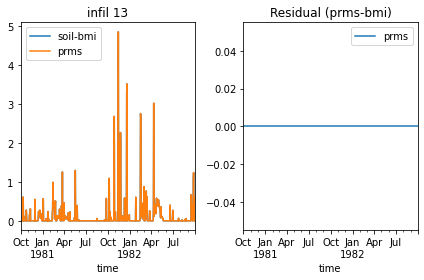

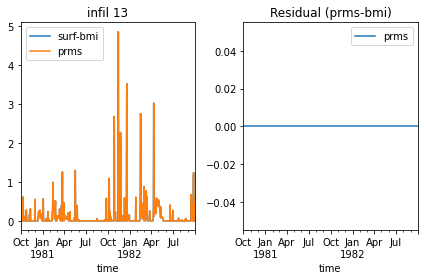

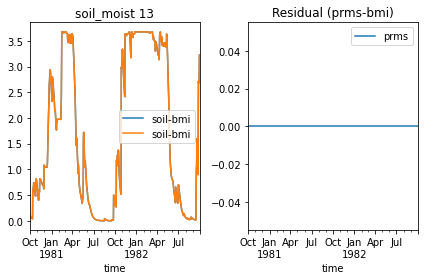

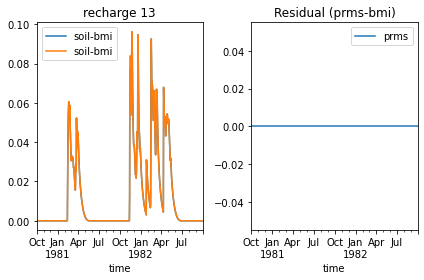

In [16]:
from helper import bmi_prms6_value_plot, bmi_prms6_residual_plot

sim_start_date = dsoil.time.min()
sim_end_date = dsoil.time.max()

t_hru = 13

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'infil', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

#This plot is just to check that the surface and soil bmi's have the same values as prms output
fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsurf, t_hru, 'infil', 'surf-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsurf, dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(ncols=2)
# bmi_prms6_value_plot(dsoil, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
# bmi_prms6_value_plot(dprms, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
# bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'sroff', 'prms', sim_start_date, sim_end_date, ax[1])
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_moist', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
bmi_prms6_value_plot(dsoil, t_hru, 'recharge', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_value_plot(dprms, t_hru, 'recharge', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'recharge', 'prms', sim_start_date, sim_end_date, ax[1])
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()

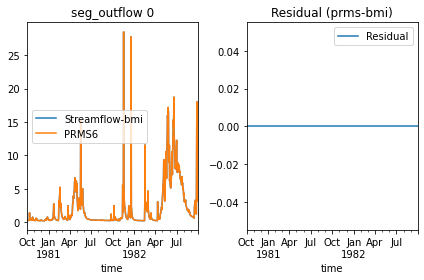

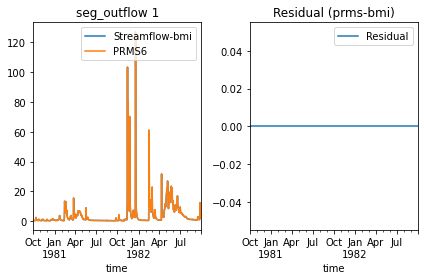

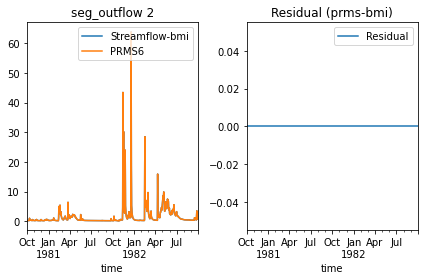

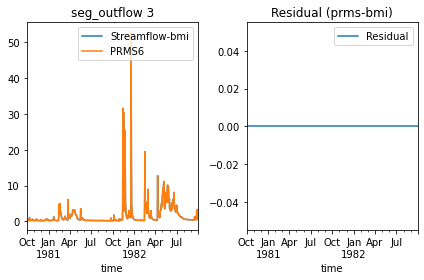

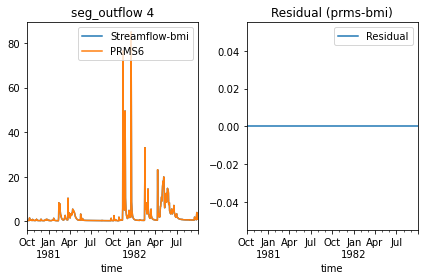

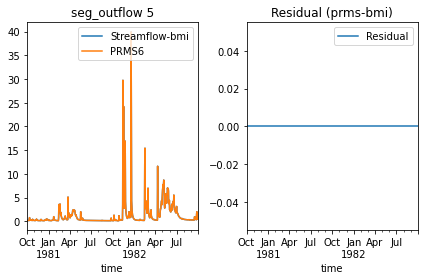

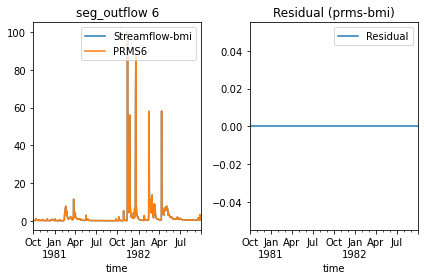

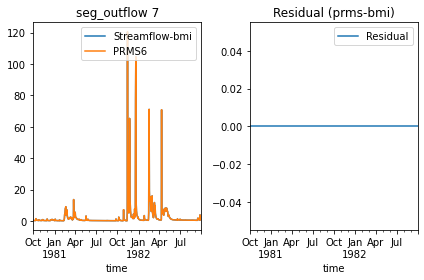

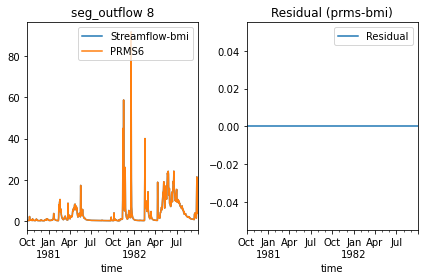

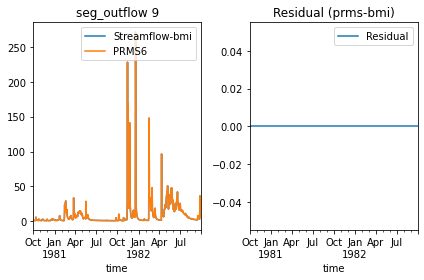

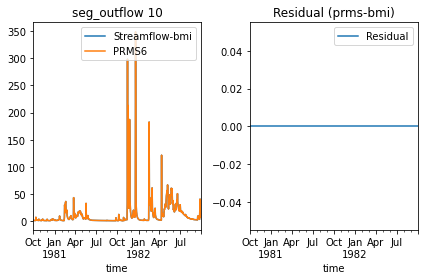

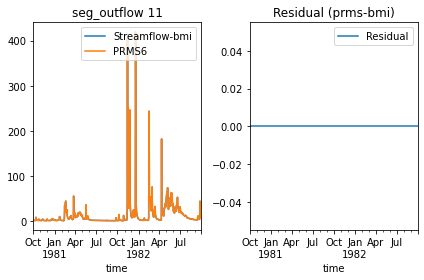

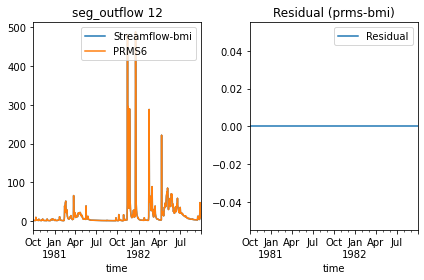

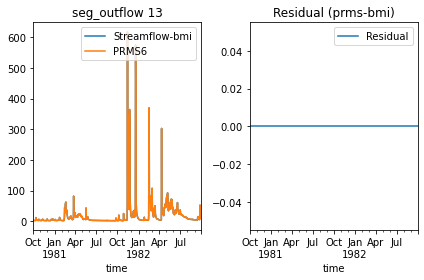

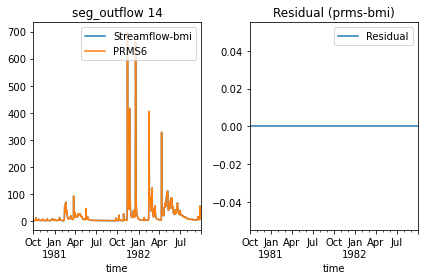

In [17]:
# for seg in dprms.nsegment:
nsegment = dprms['seg_outflow'].sizes['nsegment']
for seg in range(nsegment):
    fig, ax = plt.subplots(ncols=2)
    bmi_prms6_value_plot(dstrm, seg, 'seg_outflow', 'Streamflow-bmi', sim_start_date, sim_end_date, ax[0])
    bmi_prms6_value_plot(dprms, seg, 'seg_outflow', 'PRMS6', sim_start_date, sim_end_date, ax[0])
    bmi_prms6_residual_plot(dstrm, dprms, seg, 'seg_outflow', 'Residual', sim_start_date, sim_end_date, ax[1])
#     plt.legend()
    plt.tight_layout()
    plt.show()